In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# One-hot encoding for the target variable
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the neural network architecture
def initialize_weights(input_dim, hidden_dim, output_dim):
    w1 = np.random.randn(input_dim, hidden_dim)
    b1 = np.zeros((1, hidden_dim))
    w2 = np.random.randn(hidden_dim, output_dim)
    b2 = np.zeros((1, output_dim))
    return w1, b1, w2, b2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def forward_propagation(X, w1, b1, w2, b2):
    z1 = np.dot(X, w1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = sigmoid(z2)
    return a2

def calculate_accuracy(y_true, y_pred):
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = np.mean(y_true == y_pred)
    return accuracy

def loss_function(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def neural_network(X, w1, b1, w2, b2):
    return forward_propagation(X, w1, b1, w2, b2)

# PSO parameters
n_particles = 20
max_iter = 100
c1 = 2  # cognitive coefficient
c2 = 2  # social coefficient
w = 0.7  # inertia weight
n_features = X_train.shape[1]
n_hidden = 10
n_classes = y_train.shape[1]

# Initialize particles' positions and velocities
particles_position = []
particles_velocity = []
for _ in range(n_particles):
    w1, b1, w2, b2 = initialize_weights(n_features, n_hidden, n_classes)
    particles_position.append((w1, b1, w2, b2))
    particles_velocity.append([np.random.rand(*w.shape) for w in (w1, b1, w2, b2)])

global_best_position = None
global_best_score = float('inf')

# PSO optimization loop
for iteration in range(max_iter):
    for i, particle_position in enumerate(particles_position):
        w1, b1, w2, b2 = particle_position
        y_pred = neural_network(X_train, w1, b1, w2, b2)
        score = loss_function(y_train, y_pred)
        
        if score < global_best_score:
            global_best_position = particle_position
            global_best_score = score
        
        # Update particle's velocity
        for j in range(len(particles_velocity[i])):
            r1 = np.random.rand(*particles_velocity[i][j].shape)
            r2 = np.random.rand(*particles_velocity[i][j].shape)
            particles_velocity[i][j] = (w * particles_velocity[i][j] +
                                        c1 * r1 * (global_best_position[j] - particle_position[j]) +
                                        c2 * r2 * (particles_position[i][j] - particle_position[j]))
        
        # Update particle's position
        particles_position[i] = [p + v for p, v in zip(particle_position, particles_velocity[i])]

# Evaluate the model with the global best position found
w1, b1, w2, b2 = global_best_position
y_pred_train = neural_network(X_train, w1, b1, w2, b2)
y_pred_test = neural_network(X_test, w1, b1, w2, b2)

train_accuracy = calculate_accuracy(y_train, y_pred_train)
test_accuracy = calculate_accuracy(y_test, y_pred_test)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 0.9583333333333334
Test Accuracy: 1.0


/home/shatansh/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


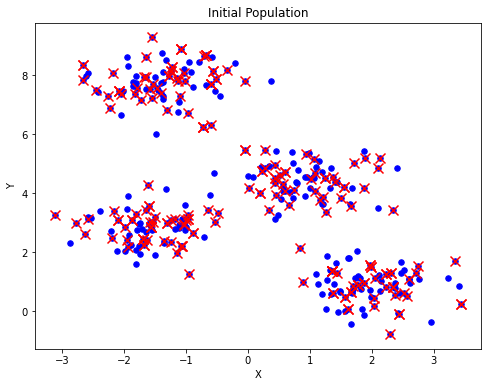

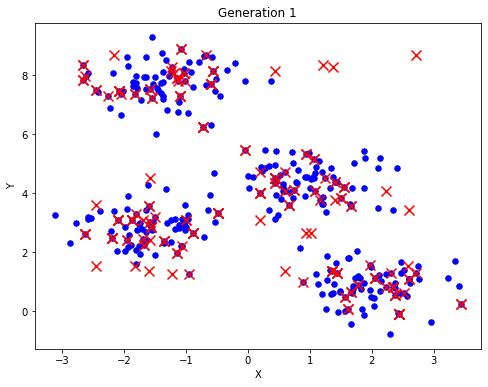

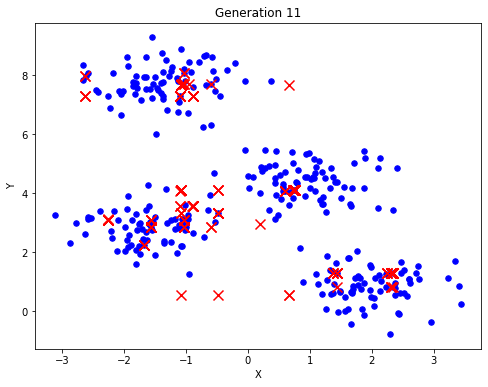

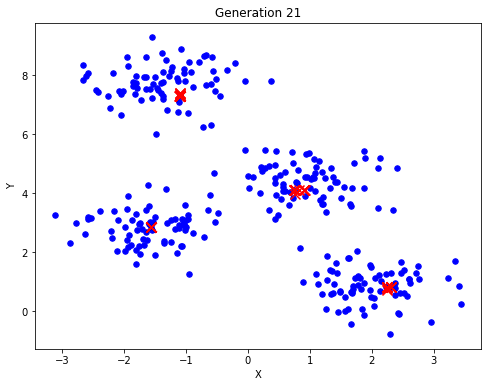

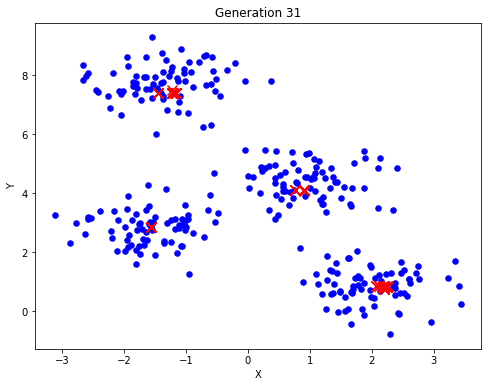

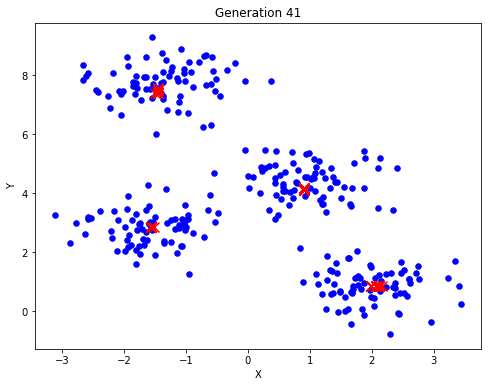

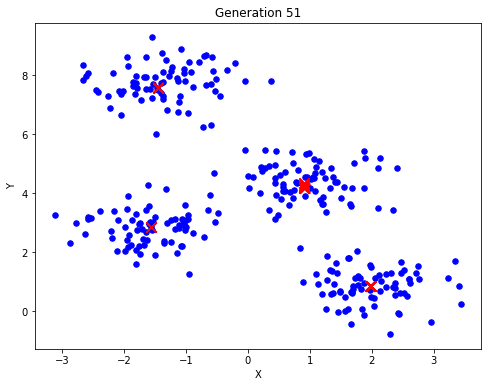

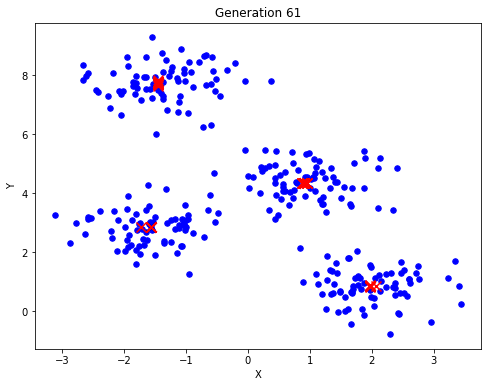

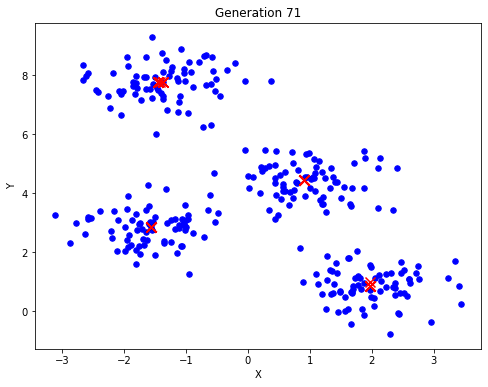

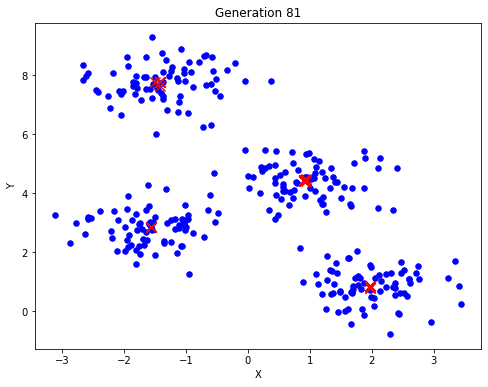

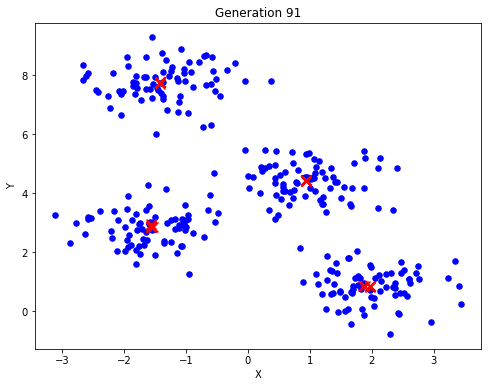

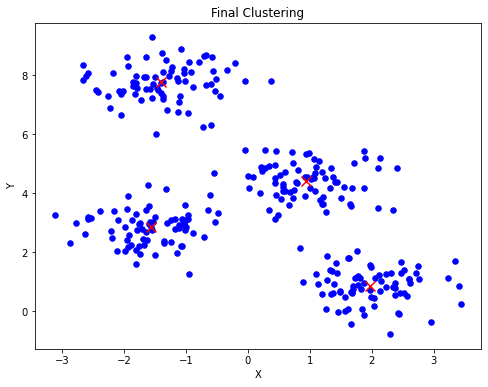

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import random
import matplotlib.pyplot as plt

def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, len(parent1))
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    return child

def mutate(individual):
    mutation_rate = 0.01
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.normal(scale=0.1)
    return individual

def fitness(X, individual, n_clusters, n_features):
    centroids = individual.reshape(n_clusters, n_features)
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    inertia = sum(np.min(distances, axis=1))
    return inertia

def plot_clusters(X, centroids_list, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c='blue', s=30)
    for centroids in centroids_list:
        centroids = centroids.reshape(n_clusters, n_features)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='x')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Generating random data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
n_clusters = 4
n_features = X.shape[1]
population_size = 50
generations = 100

population = []

# Initialize population
for _ in range(population_size):
    centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    population.append(centroids.flatten())

plot_clusters(X, population, title="Initial Population")

for generation in range(generations):
    # Select parents (top 50% of the population based on fitness)
    sorted_population = sorted(population, key=lambda ind: fitness(X, ind, n_clusters, n_features))
    selected_parents = sorted_population[:population_size // 2]

    # Crossover and mutate
    new_population = []
    for _ in range(population_size):
        parent1, parent2 = random.choices(selected_parents, k=2)
        child = crossover(parent1, parent2)
        child = mutate(child)
        new_population.append(child)

    population = new_population

    # Plot clusters and centroids for every 10 generations
    if generation % 10 == 0:
        plot_clusters(X, population, title=f"Generation {generation+1}")

# Find the best solution from the final population
best_solution = min(population, key=lambda ind: fitness(X, ind, n_clusters, n_features))
best_solution = best_solution.reshape(n_clusters, n_features)
plot_clusters(X, [best_solution.flatten()], title="Final Clustering")


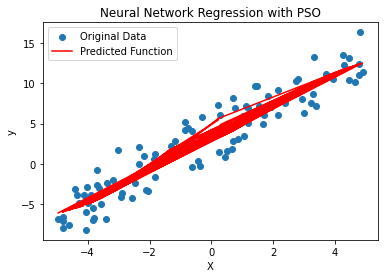

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate custom dataset
np.random.seed(0)
X = np.random.uniform(low=-5, high=5, size=(100, 1))
y = 2 * X + 3 + np.random.normal(scale=2, size=(100, 1))  # y = 2X + 3 + noise

# Define neural network architecture
def initialize_weights(input_dim, hidden_dim, output_dim):
    w1 = np.random.randn(input_dim, hidden_dim)
    b1 = np.zeros((1, hidden_dim))
    w2 = np.random.randn(hidden_dim, output_dim)
    b2 = np.zeros((1, output_dim))
    return w1, b1, w2, b2

def forward_propagation(X, w1, b1, w2, b2):
    z1 = np.dot(X, w1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, w2) + b2
    return z2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def neural_network(X, w1, b1, w2, b2):
    return forward_propagation(X, w1, b1, w2, b2)

# Particle Swarm Optimization (PSO)
def pso(X, y, n_particles, max_iter, input_dim, hidden_dim, output_dim):
    # PSO parameters
    c1 = 2  # cognitive coefficient
    c2 = 2  # social coefficient
    w = 0.7  # inertia weight
    
    # Initialize particles' positions and velocities
    particles_position = []
    particles_velocity = []
    for _ in range(n_particles):
        w1, b1, w2, b2 = initialize_weights(input_dim, hidden_dim, output_dim)
        particles_position.append((w1, b1, w2, b2))
        particles_velocity.append([np.random.rand(*w.shape) for w in (w1, b1, w2, b2)])
    
    global_best_position = None
    global_best_score = float('inf')
    
    # PSO optimization loop
    for iteration in range(max_iter):
        for i, particle_position in enumerate(particles_position):
            w1, b1, w2, b2 = particle_position
            y_pred = neural_network(X, w1, b1, w2, b2)
            score = mean_squared_error(y, y_pred)
            
            if score < global_best_score:
                global_best_position = particle_position
                global_best_score = score
            
            # Update particle's velocity
            for j in range(len(particles_velocity[i])):
                r1 = np.random.rand(*particles_velocity[i][j].shape)
                r2 = np.random.rand(*particles_velocity[i][j].shape)
                particles_velocity[i][j] = (w * particles_velocity[i][j] +
                                            c1 * r1 * (global_best_position[j] - particle_position[j]) +
                                            c2 * r2 * (particles_position[i][j] - particle_position[j]))
            
            # Update particle's position
            particles_position[i] = [p + v for p, v in zip(particle_position, particles_velocity[i])]
    
    # Return the best solution found
    return global_best_position

# Train the neural network using PSO
input_dim = X.shape[1]
hidden_dim = 10
output_dim = 1
n_particles = 20
max_iter = 100

best_solution = pso(X, y, n_particles, max_iter, input_dim, hidden_dim, output_dim)

# Evaluate the model with the global best position found
w1, b1, w2, b2 = best_solution
y_pred = neural_network(X, w1, b1, w2, b2)

# Plot the original data and the predicted function
plt.scatter(X, y, label='Original Data')
plt.plot(X, y_pred, color='red', label='Predicted Function')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Neural Network Regression with PSO')
plt.legend()
plt.show()
